<a href="https://colab.research.google.com/github/probml/ssm-jax/blob/main/ssm_jax/hmm/demos/casino_hmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Occasionally dishonest Casino" HMM

Based on https://github.com/probml/JSL/blob/main/jsl/demos/hmm_casino.py


# Setup

In [1]:
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

In [2]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax 

In [3]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit, value_and_grad

import matplotlib.pyplot as plt
import numpy as np

from ssm_jax.hmm.models import CategoricalHMM
import ssm_jax.hmm.learning as learning
import ssm_jax.misc.plot_utils as plot_utils

In [4]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging
logger = logging.getLogger() 

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# Model

In [5]:
transition_matrix = jnp.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

emission_probs = jnp.array([
    [1/6,  1/6,  1/6,  1/6,  1/6,  1/6],  # fair die
    [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]  # loaded die
])

init_state_probs = jnp.array([1/2, 1/2])

hmm = CategoricalHMM(init_state_probs, transition_matrix, emission_probs)

# Generate samples

In [6]:
n_timesteps = 300
true_states, emissions = hmm.sample(jr.PRNGKey(0), n_timesteps)

print("Printing sample observed/latent...")
to_string = lambda x: "".join((np.array(x) + 1).astype(str))[:60]
print("obs: ", to_string(true_states)[:60])
print("hid: ", to_string(emissions)[:60])

Printing sample observed/latent...
obs:  111111111122221111111111111111111111222222222122221111111111
hid:  135553452655336631635155152623211211346222126326426542234464


# Inference

In [7]:
posterior = hmm.smoother(emissions)
print("Log likelihood: ", posterior.marginal_log_lkhd)

Log likelihood:  -523.9222


In [8]:
most_likely_states = hmm.most_likely_states(emissions)
print("most likely states:", to_string(most_likely_states)[:60])

most likely states: 111111111111111111111111111111111111111111111111111111111111


# Plot results

In [9]:
def find_dishonest_intervals(states):
    """
    Find the span of timesteps that the
    simulated systems turns to be in state 1
    Parameters
    ----------
    states: array(n_timesteps)
        Result of running the system with two
        latent states
    Returns
    -------
    list of tuples with span of values
    """
    states = np.array(states)
    changepoints = np.concatenate(
        [[0], np.nonzero(np.diff(states))[0] + 1, [len(states)]])
    starts, ends = changepoints[:-1], changepoints[1:]
    
    # Return the (start, end) pairs where the start state is 1
    dishonest = states[starts] == 1
    return list(zip(starts[dishonest], ends[dishonest]))

In [10]:
def plot_inference(inference_values, states, ax, state=1, map_estimate=False):
    """
    Plot the estimated smoothing/filtering/map of a sequence of hidden states.
    "Vertical gray bars denote times when the hidden
    state corresponded to state 1. Blue lines represent the
    posterior probability of being in that state given diﬀerent subsets
    of observed data." See Markov and Hidden Markov models section for more info
    Parameters
    ----------
    inference_values: array(n_timesteps, state_size)
        Result of running smoothing method
    states: array(n_timesteps)
        Latent simulation
    ax: matplotlib.axes
    state: int
        Decide which state to highlight
    map_estimate: bool
        Whether to plot steps (simple plot if False)
    """
    n_timesteps = len(inference_values)
    xspan = np.arange(1, n_timesteps + 1)
    spans = find_dishonest_intervals(states)
    if map_estimate:
        ax.step(xspan, inference_values, where="post")
    else:
        ax.plot(xspan, inference_values[:, state])

    for span in spans:
        ax.axvspan(*span, alpha=0.5, facecolor="tab:gray", edgecolor="none")
    ax.set_xlim(1, n_timesteps)
    # ax.set_ylim(0, 1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Observation number")

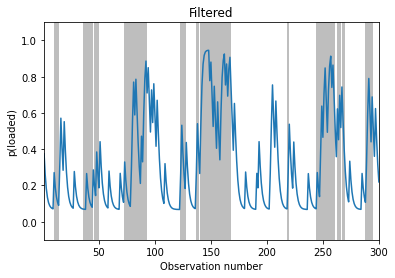

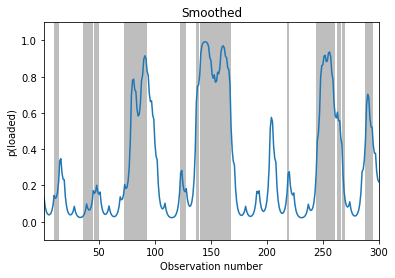

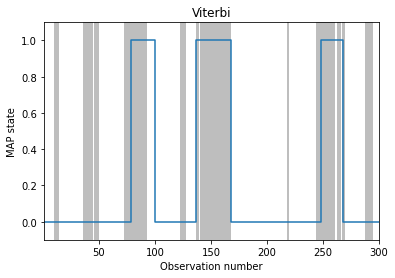

In [11]:
dict_figures = {}

# Plot results
fig, ax = plt.subplots()
plot_inference(posterior.filtered_probs, true_states, ax)
ax.set_ylabel("p(loaded)")
ax.set_title("Filtered")
dict_figures["hmm_casino_filter"] = fig

fig, ax = plt.subplots()
plot_inference(posterior.smoothed_probs, true_states, ax)
ax.set_ylabel("p(loaded)")
ax.set_title("Smoothed")
dict_figures["hmm_casino_smooth"] = fig

fig, ax = plt.subplots()
plot_inference(most_likely_states, true_states, ax, map_estimate=True)
ax.set_ylabel("MAP state")
ax.set_title("Viterbi")
dict_figures["hmm_casino_map"] = fig

plt.show()

# Draw model

In [12]:
def savedotfile(dotfiles):
  if "FIGDIR" in os.environ:
      figdir = os.environ["FIGDIR"]
      for name, dot in dotfiles.items():
          fname_full = os.path.join(figdir, name)
          dot.render(fname_full)
          print(f"saving dot file to {fname_full}")

